# Tarifes AMB: Desplaçament esporàdic en grup

Avui s'han fet públiques les tarifes del transport públic a l'Àrea Metropolitana de Barcelona (AMB) pel 2020. Aquestes tarifes aposten per títols unipersonals i per un us habitual i regular del **transport públic** enlloc d'apostar per tots els mètodes de transport sostenibles. 

Aquesta llibreta intentarà analitzar la mobilitat dels **grups**. Aquí cal notar que el ser usuari habitual del transport públic no té perqué voler dir que no es serà usuari del transport públic en grup. Tothom que tingui una T-Usual, T-Jove o T-16 necessitarà un altre títol quan es desplaci fora de la seva zona de residencia i/o mobilitat habitual. Poso alguns exemples:
* Els infants amb T-16 residents a Sant Cugat, Rubí, Sabadell o Cerdanyola (entre altres) necessiten un títol de 2 zones per poder anar a Terrassa (aquest moviment és habitual per exemple per anar a l'hospital)
* Tothom que tingui una T-Usual o T-Jove de 1 o 2 zones, si un dia decideix anar a Montserrat d'excursió o a Arenys a la platja necessitarà un títol especial pel viatge.

És evident que les noves tarifes penalitzen l'ús esporàdic del transport públic, de fet és un dels objectius segons han dit en roda de premsa. Aquest codi permet quantificar aquesta penalització, que poc o molt afecta a tothom però en especial a grups tirant a nombrosos que tant poden ser escoles, esplais o caus com entitats de lleure per persones amb discapacitat intel·lectual.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(display_style="html");

import arviz as az

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
preus_2019 = xr.load_dataarray("preus_atm.nc", group="2019")

In [4]:
preus_2020 = xr.load_dataarray("preus_atm.nc", group="2020")

In [5]:
tipus_bitllets = {
    "senzill": 1,
    "t-10": 10,
    "t-70/30": 70,
    "t-grup": 70,
}
def preu_viatges_grup(
    n_persones, n_viatges=2, bitllet="senzill", zones=1, tarifa=2019, bonificacio="cap"
):
    """Calcula el preu mensual segons el nombre de viatges.
    
    Parameters
    ----------
    n_persones: int or array-like
        Nombre de persones al grup
    n_viatges: int or array-like
        Nombre de viatges que ha de fer el grup
    bitllet: str, opcional
        Tipus de bitllet
    zones: int, opcional
        Nombre de zones del bitllet
    tarifa: int, opcional
        Utilitzar les tarifes vigents l'any ``tarifa``
    bonificacio: str, opcional
        Quina bonificació cal utilitzar per fer el calcul
    
    Returns
    -------
    int
        Preu mensual en euros
    """
    n_persones = np.asarray(n_persones)
    bitllet = bitllet.lower()
    if tarifa == 2019:
        data = preus_2019
    elif tarifa == 2020:
        data = preus_2020
    else:
        raise ValueError("No hi ha dades de l'any {}".format(tarifa))
    if bitllet not in tipus_bitllets:
        raise ValueError("Els bitllets han de ser multipersonals")
    tipus_bitllet = tipus_bitllets[bitllet]
    preu = data.sel(
            bitllet=bitllet, zona=zones, bonificacio=bonificacio
        ).values
    bitllets, extra = np.divmod(n_persones * n_viatges, tipus_bitllet)
    return (bitllets + np.array(extra != 0, dtype=np.int)) * preu

In [6]:
preu_viatges_grup(11, 2, bitllet="t-10")

30.599999999999998

In [7]:
def compara_bitllets(bitllets, ax, persones=None, legend_title=None, plot_kwargs=None, **kwargs):
    """Compara diferents bitllets multipersonals.
    
    Parameters
    ----------
    bitllets: array-like
    ax: matplotlib axes
    persones: array-like
    kwargs: mapping
        Els kwargs es passen directament a ``preu_per_mes``
    """
    if persones is None:
        persones = np.arange(1, 40)
    for i, bitllet in enumerate(bitllets):
        if plot_kwargs is None:
            un_plot_kwargs = {}
        elif isinstance(plot_kwargs, list):
            un_plot_kwargs = plot_kwargs[i]
        else:
            un_plot_kwargs = {**plot_kwargs}
        un_plot_kwargs.setdefault("label", bitllet)
        un_plot_kwargs.setdefault("drawstyle", "steps-post")
        ax.plot(
            persones, 
            preu_viatges_grup(persones, bitllet=bitllet, **kwargs), 
            **un_plot_kwargs
        )
    ax.set_ylim(bottom=0)   
    ax.legend(loc="upper left", title=legend_title)
    return ax

def preu_minim(bitllets, ax, persones=None, plot_kwargs=None, **kwargs):
    if persones is None:
        persones = np.arange(1, 40)
    if plot_kwargs is None:
        plot_kwargs = {}
    plot_kwargs.setdefault("drawstyle", "steps-post")
    preu_n_persones = np.full_like(persones, np.infty, dtype=np.float)
    n_viatges = kwargs.get("n_viatges", 2)
    for bitllet in bitllets:
        preu_bitllet = preu_viatges_grup(persones, bitllet=bitllet, **kwargs)
        mask_70_30 = persones * n_viatges > 70
        if np.any(mask_70_30):
            preu_bitllet[mask_70_30] = preu_viatges_grup(
                (persones[mask_70_30] * n_viatges) - 70, 
                n_viatges=1,
                bitllet=bitllet, 
                **{k: v for k, v in kwargs.items() if k != "n_viatges"}
            ) + preu_viatges_grup(
                70, 
                n_viatges=1, 
                bitllet="t-grup" if kwargs.get("tarifa", 2019) == 2020 else "t-70/30",
                **kwargs
            )
        mask = preu_bitllet < preu_n_persones
        preu_n_persones[mask] = preu_bitllet[mask]
    ax.plot(persones, preu_n_persones, **plot_kwargs)
    return preu_n_persones

Text(0.5, 0.98, 'Preu anada i tornada')

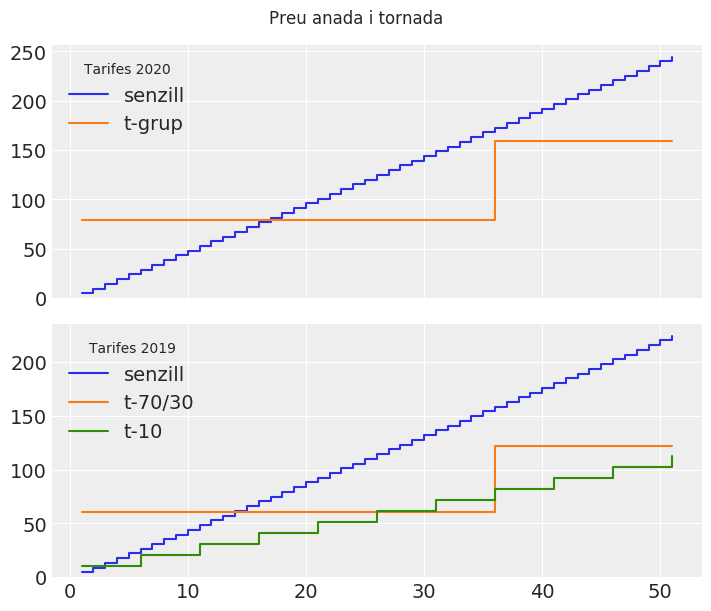

In [8]:
fig, ax = plt.subplots(
    2, 1, figsize=(7, 6), sharex=True, constrained_layout=True
)
bitllets_2019 = ["senzill", "t-70/30", "t-10"]
bitllets_2020 = ["senzill", "t-grup"]
compara_bitllets(
    bitllets_2020, 
    ax[0], 
    tarifa=2020, 
    persones=np.arange(1,52),
    legend_title="Tarifes 2020"
)
compara_bitllets(
    bitllets_2019, 
    ax[1], 
    tarifa=2019, 
    persones=np.arange(1,52),
    legend_title="Tarifes 2019"
);
fig.suptitle("Preu anada i tornada")

En el cas de viatges d'anada i tornada, amb les tarifes del 2020, a partir de més de 16 persones ja surt a compte comprar-la. És a dir, un grup de 17 persones pagarà menys agafant una T-grup i desaprofitant més de la meitat dels viatges que comprant bitllets senzills per cadascú. Sembla un canvi una míca brusc passar d'un títol d'un viatge a un de 70 sense res entre mig.

Amb les tarifes de 2019 en canvi, a partir de 3 persones al grup surt més a compte comprar una T-10, entre 25 i 30 tant T-10 com T-70/30 costen gairebé el mateixi a partir de 31 persones surt més a compte la T-70/30. En aquest cas una T-70/30 de la qual es gasten menys de 50-60 viatges no surt a compte. 

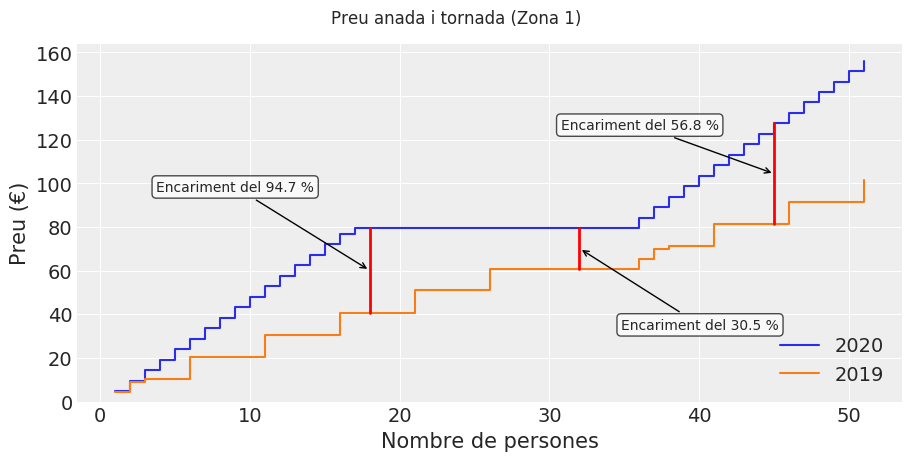

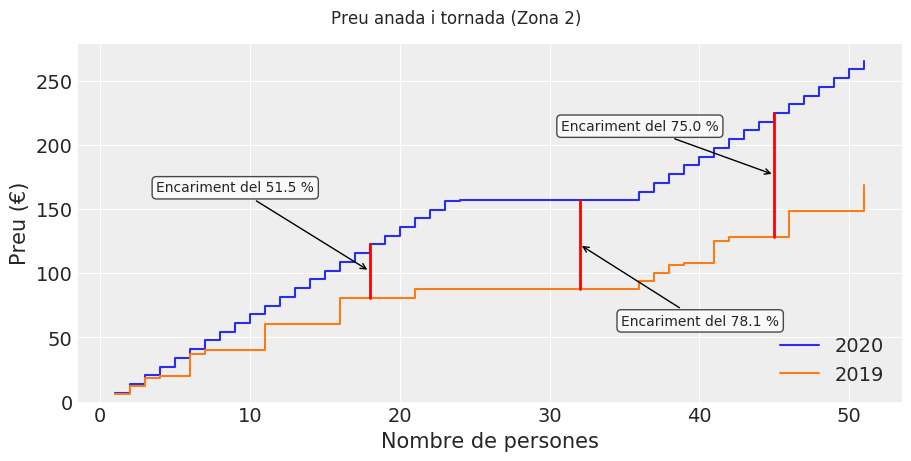

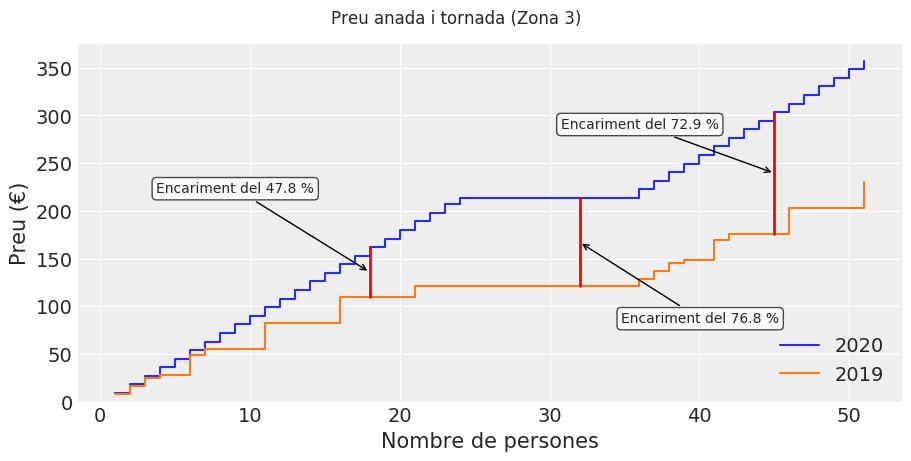

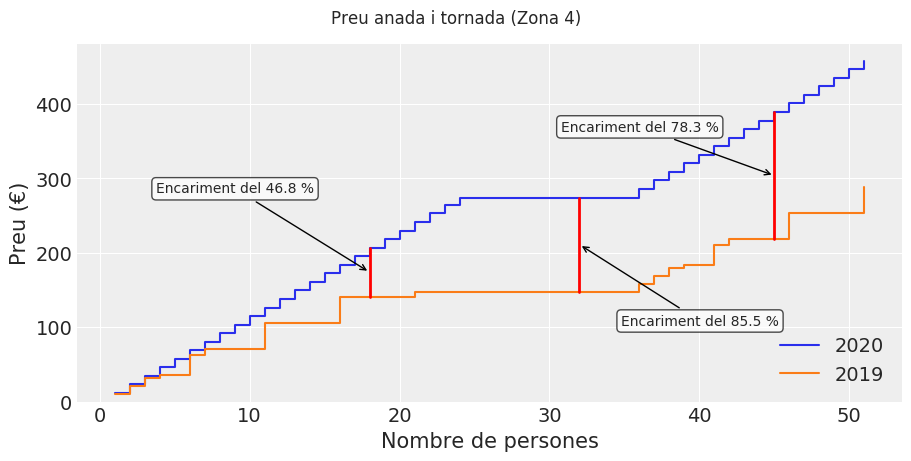

In [9]:
persones=np.arange(1,52)
bitllets_2019 = ["senzill", "t-10", "t-70/30"]
bitllets_2020 = ["senzill", "t-grup"]
zona = 3
n_viatges = 2
for zona in range(1,5):
    fig, ax = plt.subplots(1, 1, figsize=(9, 4.5), sharey=True, constrained_layout=True)
    preu_minim_2020 = preu_minim(
        bitllets_2020, 
        ax, 
        tarifa=2020, 
        persones=persones,
        plot_kwargs={"label": "2020"},
        zones=zona
    )
    preu_minim_2019 = preu_minim(
        bitllets_2019, 
        ax, 
        tarifa=2019, 
        persones=persones,
        plot_kwargs={"label": "2019"},
        zones=zona
    );
    ax.legend(loc="lower right")
    ax.grid(True)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Preu (€)")
    ax.set_xlabel("Nombre de persones")
    for vline, x, y, ha, va, in (
        [18, -40, 55, "right", "bottom"], 
        [32, 30, -50, "left", "top"], 
        [45, -40, 30, "right", "bottom"]
    ):
        preu_2019 = preu_minim_2019[persones == vline].item()
        preu_2020 = preu_minim_2020[persones == vline].item()
        estalvi = (preu_2020 - preu_2019) / preu_2019 * 100
        ax.plot([vline, vline], [preu_2020, preu_2019], color="r", lw=2)
        ax.annotate(
            "Encariment del {:.1f} %".format(estalvi),
            xy=(vline, (preu_2019 + preu_2020)/2),
            xytext=(x, y),
            textcoords="offset points",
            bbox=dict(boxstyle="round", fc="w", alpha=.7),
            arrowprops=dict(arrowstyle="->"),
            ha=ha,
            va=va
        );
    if n_viatges == 2:
        n_viatges = "anada i tornada"
    fig.suptitle("Preu {} (Zona {})".format(n_viatges, zona));